In [1]:
# import requirements
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("data.csv")
df = df[['order_id', 'shop_id', 'order_amount', 'total_items']]
#df.columns
df.head()

,order_id,shop_id,order_amount,total_items
0,1,53,224,2
1,2,92,90,1
2,3,44,144,1
3,4,18,156,1
4,5,18,156,1


In [3]:
df.describe()

,order_id,shop_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,3145.128000,8.78720
std,1443.520003,29.006118,41282.539349,116.32032
min,1.000000,1.000000,90.000000,1.00000
25%,1250.750000,24.000000,163.000000,1.00000
50%,2500.500000,50.000000,284.000000,2.00000
75%,3750.250000,75.000000,390.000000,3.00000
max,5000.000000,100.000000,704000.000000,2000.00000


### Naive AOV


In [4]:
#bad_aov = df['order_amount'].sum() / df['total_items'].count()
bad_aov = df['order_amount'].mean()
round(bad_aov, 2)


3145.13

<AxesSubplot:>

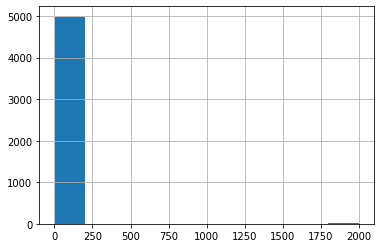

In [5]:
df['total_items'].hist(bins=10)
#sns.distplot(df['total_items'])


### Issues
* We are not accounting for bulk order sizes (anamolies) that skew the averages
* We are not accounting for luxury or rare sneakers (outliers) that skew the averages


### Alterntaive Method A
1. Compute the average price of an item
2. Compute the median or mode of the order sizes (median or mode of total_items)
3. Multiply the median or mode of the order sizes (same in this case) by the average price per item to get AOV

### Alternative Method B
1. Detect the outliers in the order sizes (bulk orders) and avg sneaker price (luxury or rare sneakers)
2. Remove the outliers
3. Compute AOV as it was computed originally

In [6]:
# Alternative Method A

df['avg_item_price'] = df.apply (lambda row: row.order_amount / row.total_items, axis=1)
df['avg_item_price'].head()

# Compute the average price of an item
avg_item_price = df['avg_item_price'].mean()
avg_item_price = round(avg_item_price, 2)

# Compute the median or mode of the order sizes (median or mode of total_items)
order_size_mode = df['total_items'].mode()
order_size_median = df['total_items'].median()

print("Average Item Price: ", avg_item_price)
print("Order Size Mode: ", order_size_mode)
print("Order Size Median: ", order_size_median)

# Multiply the median or mode of the order sizes (same in this case) by the average price per item
avg_order_value = avg_item_price * order_size_mode
avg_order_value = round(avg_order_value, 2)


print("Average Order Value (AOV): ", avg_order_value)



Average Item Price:  387.74
Order Size Mode:  0    2
dtype: int64
Order Size Median:  2.0
Average Order Value (AOV):  0    775.48
dtype: float64


In [7]:
# Alternative Method B
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor

import numpy as np

isof = IsolationForest(n_estimators=10)
knn = NearestNeighbors(n_neighbors = 1, algorithm = "ball_tree", p=1)
svm = OneClassSVM(gamma = 'scale')
model = LocalOutlierFactor(n_neighbors=800, contamination=0.01)

#X = np.array(df['order_amount']).reshape(-1, 1)
X = df[['order_amount', 'total_items', 'avg_item_price']]

isof.fit(X)
knn.fit(X)
svm.fit(X)

df['anomaly'] = model.fit_predict(X)


df.head()

,order_id,shop_id,order_amount,total_items,avg_item_price,anomaly
0,1,53,224,2,112.0,1
1,2,92,90,1,90.0,1
2,3,44,144,1,144.0,1
3,4,18,156,1,156.0,1
4,5,18,156,1,156.0,1


In [8]:
anomaly = df.loc[df['anomaly']==-1]
anomaly_index=list(anomaly.index)

anomaly.to_csv("anamolies.csv")
print(anomaly)
print("Num of outliers: ", len(anomaly))

      order_id  shop_id  order_amount  total_items  avg_item_price  anomaly
15          16       42        704000         2000           352.0       -1
60          61       42        704000         2000           352.0       -1
490        491       78         51450            2         25725.0       -1
493        494       78         51450            2         25725.0       -1
511        512       78         51450            2         25725.0       -1
520        521       42        704000         2000           352.0       -1
617        618       78         51450            2         25725.0       -1
691        692       78        154350            6         25725.0       -1
1104      1105       42        704000         2000           352.0       -1
1259      1260       78         77175            3         25725.0       -1
1362      1363       42        704000         2000           352.0       -1
1436      1437       42        704000         2000           352.0       -1
1529      15

In [9]:
outliers_counter = len(df[df['avg_item_price'] > 2.5 * avg_item_price]) 
# sneaker prices tend to not have that much variance so 2.5 is appropriate treshold to dictate outlier
outliers_counter

46

In [10]:
# Anamoly Detection Model Accuracy

num_anam = list(df['anomaly']).count(-1)
#num_anam = 46

accuracy = num_anam / outliers_counter * 100

print("Accuracy percentage:", accuracy)

Accuracy percentage: 95.65217391304348


In [11]:
# drop anamolies
df = df[df.anomaly == 1]
df.to_csv("df_no_anoms.csv")
df.order_id.count()


4956

In [12]:
# compute average order value as it was computed originally with all the outliers removed from the order size and avg item price
good_aov = df['order_amount'].mean()
good_aov = round(good_aov, 2)

### Better methods Final Answers

In [13]:
print("Method 1 - Average Order Value (AOV) : ", avg_order_value)
print("Method 2 - Average Order Value (AOV) : ", good_aov)
print("Avg of both AOVs : ", (avg_order_value + good_aov) / 2)

print("we can also just use raw MEDIAN order value and MODE order value instead of the AOV")
print("Median Order Value: ", df['order_amount'].median())
print("Mode Order Value: ", df['order_amount'].mode())

Method 1 - Average Order Value (AOV) :  0    775.48
dtype: float64
Method 2 - Average Order Value (AOV) :  400.04
Avg of both AOVs :  0    587.76
dtype: float64
we can also just use raw MEDIAN order value and MODE order value instead of the AOV
Median Order Value:  284.0
Mode Order Value:  0    153
dtype: int64


### Question b)
* We can use a variety of different metrics for this dataset
* We can simply use Median or Mode or alternative we could use the following additional metrics:
    1. AOV by Shop
        * this allows us to use an appropriate AOV accounting for the different store types
        * if a store sell's luxury or rare sneakers than they will have smaller order size in terms of quantity but very large    AOV driven by higher avg price per sneaker
    2. AOV by Customer  
        * similar to AOV by store; segment by wholesale buyer vs retail buyer
    2. AOV by Payment method
        * similar to AOV by store; larger orders (bulk) or more expensive orders are usually placed on credit rather than debit/cash
    

In [14]:
# Mode and Median
df = pd.read_csv("data.csv")
print("Median Order Value: ", df['order_amount'].median())
print("Mode Order Value: ", df['order_amount'].mode())

Median Order Value:  284.0
Mode Order Value:  0    153
dtype: int64


In [15]:
# AOV by Shop

df = pd.read_csv("data.csv")

table = pd.pivot_table(df, values=['order_amount', 'total_items'], index=['shop_id'],
                    aggfunc={'order_amount': np.mean,
                             'total_items': np.mean})

table.to_csv("aov_by_shop.csv")

result = table.sort_values(('order_amount'), ascending=False)
print(result)


          order_amount  total_items
shop_id                            
42       235101.490196   667.901961
78        49213.043478     1.913043
50          403.545455     2.090909
90          403.224490     2.265306
38          390.857143     2.057143
...                ...          ...
53          214.117647     1.911765
100         213.675000     1.925000
32          189.976190     1.880952
2           174.327273     1.854545
92          162.857143     1.809524

[100 rows x 2 columns]


In [16]:
# AOV by Customer

df = pd.read_csv("data.csv")

table = pd.pivot_table(df, values=['order_amount', 'total_items'], index=['user_id'],
                    aggfunc={'order_amount': np.mean,
                             'total_items': np.mean})

table.to_csv("aov_by_customers.csv")

result = table.sort_values(('order_amount'), ascending=False)
print(result)

          order_amount  total_items
user_id                            
607      704000.000000  2000.000000
878       14266.909091     2.181818
766        8007.600000     2.300000
834        6019.000000     2.111111
915        5785.142857     2.071429
...                ...          ...
892         227.307692     1.538462
899         226.666667     1.666667
827         226.500000     1.500000
939         219.600000     1.500000
864         209.157895     1.473684

[301 rows x 2 columns]
